# PubMLP: Automatic Publication Classifier

---

Mikyung Shin | February 22, 2024  

[<img src="https://huggingface.co/datasets/huggingface/brand-assets/resolve/main/hf-logo.svg" width="20"/> Hugging Face](https://huggingface.co/mshin/PubMLP) | [<img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width="20"/> GitHub](https://github.com/mshin77/PubMLP) | [<img src="https://assets.dryicons.com/uploads/icon/svg/5923/473dc604-c750-41f5-b394-1b9d1799ff06.svg" width="20"/> Documentation](https://mshin77.github.io/PubMLP)

##### PubMLP is a PyTorch module for a Multilayer Perceptron (MLP) model with BERT embeddings.


## 1. Set Up
##### Install and load Python libraries.

In [1]:
# "conda activate python-venv" in the terminal
# !pip install -r requirements.txt

In [2]:
# Access files and folders within your Google Drive
from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata
userdata.get('HF_TOKEN')

%cd /content/drive/My\ Drive/Colab\ Notebooks/LLM/PubMLP
# %cd "G:/My Drive/Colab Notebooks/LLM/PubMLP"

# Import Python libraries
import ipywidgets as widgets
import pandas as pd
import numpy as np
import spacy
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sources.prepare import extract_country_entities, split_data
from sources.preprocess import preprocess_dataset, create_dataloader
from sources.model import PubMLP, calculate_loss, calculate_accuracy, train_evaluate_model, predict_model
from sources.plot import plot_results
import warnings

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/LLM/PubMLP


## 2. Labeled Data

##### Prepare data for training, validation, and testing.


In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)

# Load data
labeled_data = pd.read_csv("./files/1_labeled_data.csv")

# create a new 'Country' column
ner_model = spacy.load("en_core_web_sm")

In [4]:
labeled_data["Country"] = labeled_data["C1"].apply(
    lambda x: extract_country_entities(x, ner_model)
)

# Select relevant columns
labeled_df = labeled_data[['UT', 'single_case', 'PY', 'AF', 'TI', 'AB', 'DE', 'ID', 'SO', 'Country']]
labeled_df = labeled_df.copy()

missing_values = labeled_df.isnull().sum()
print(missing_values)

df = labeled_df.copy()

# Convert to numeric data
df["PY"] = pd.to_numeric(df["PY"], errors='coerce')

# Replace missing values
df.dropna(subset=["PY"], inplace=True)

train_df, validation_df, test_df = split_data(df)

print(f"Training data number: {len(train_df)}")
print(f"Validation data number: {len(validation_df)}")
print(f"Testing data number: {len(test_df)}")

UT               0
single_case      0
PY               0
AF               0
TI               0
AB               0
DE             311
ID             201
SO               0
Country          0
dtype: int64
Training data number: 1438
Validation data number: 180
Testing data number: 180


##### Preprocess data and convert to dataloaders.


In [5]:
warnings.filterwarnings('ignore', category=FutureWarning)

# Configure reproducible environments
torch.backends.cudnn.deterministic = True
random_seed = 2024
torch.manual_seed(random_seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# Define columns for preprocessing
col_lists = {
    "text_cols": ['AF', 'TI', 'AB', 'DE', 'ID', 'Country'],
    "categorical_cols": ['SO'],
    "numeric_cols": ['PY'],
    "label_col": ['single_case']
}

# Define transformation options for numeric data
numeric_transform = {
    'PY': 'min'
}

label_col = col_lists['label_col'][0]

train_df[label_col] = train_df[label_col].map({'yes': 1, 'no': 0})
validation_df[label_col] = validation_df[label_col].map({'yes': 1, 'no': 0})
test_df[label_col] = test_df[label_col].map({'yes': 1, 'no': 0})

# Preprocess and create dataloaders
train_dataset = preprocess_dataset(train_df, tokenizer, device, col_lists, numeric_transform)
train_dataloader = create_dataloader(train_dataset, RandomSampler, batch_size=8)

validation_dataset = preprocess_dataset(validation_df, tokenizer, device, col_lists, numeric_transform)
validation_dataloader = create_dataloader(validation_dataset, SequentialSampler, batch_size=8)

test_dataset = preprocess_dataset(test_df, tokenizer, device, col_lists, numeric_transform)
test_dataloader = create_dataloader(test_dataset, SequentialSampler, batch_size=8)

Preprocessed data saved to preprocessed_data_single_case_02252024_191935.xlsx
Preprocessed data saved to preprocessed_data_single_case_02252024_191936.xlsx
Preprocessed data saved to preprocessed_data_single_case_02252024_191938.xlsx


## 3. Train

##### Train the model and perform validation.

In [6]:
# Initialize the PubMLP model which is based on the BERT model
model = PubMLP(numeric_cols_num=1,
               mlp_hidden_size=16,
               output_size=1,
               dropout_rate=0.2).to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optim = AdamW(model.parameters(), lr=5e-5, eps = 1e-8)

# Number of training epochs
epochs = 2

# Evaluate PubMLP model
train_losses, validation_losses, train_accuracies, validation_accuracies, test_accuracy, best_val_loss, best_model_state = train_evaluate_model(model, train_dataloader, validation_dataloader, test_dataloader, optim, criterion, device, epochs)

torch.save(best_model_state, "best_model_state.pth")

Epoch: 0001/0002 | Training Loss: 0.521 | Validation Loss: 0.325
Training Accuracy: 93.672% | Validation Accuracy: 91.667%
Time elapsed: 0.79 min
Epoch: 0002/0002 | Training Loss: 0.356 | Validation Loss: 0.273
Training Accuracy: 95.132% | Validation Accuracy: 92.222%
Time elapsed: 1.56 min
Test Accuracy: 92.222%


##### Plot results.

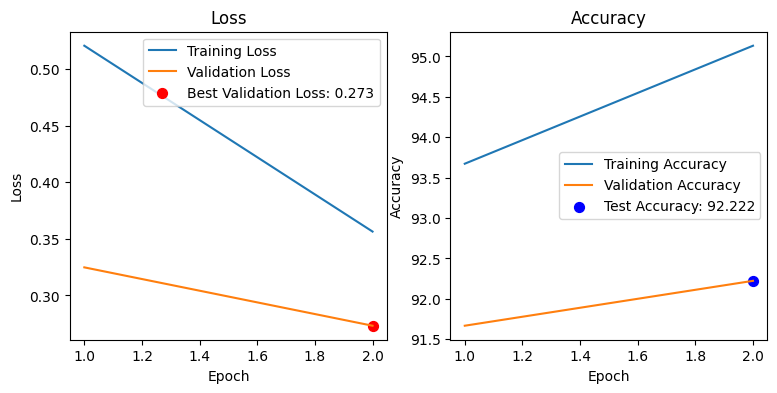

In [7]:
plot_results(train_losses, validation_losses, train_accuracies, validation_accuracies, test_accuracy, best_val_loss)

## 4. Unlabeled Data

##### Filter rows where "single_case" is NA (not labeled).

In [8]:
# Ignore warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='huggingface_hub')
warnings.filterwarnings('ignore', message="^.*\[W111\].*$")

labeled_data = pd.read_csv("files/1_labeled_data.csv")
init_all_data = pd.read_csv("files/2_init_all_data.csv")

init_all_data = pd.merge(init_all_data, labeled_data, on="UT", how="left", suffixes=("", "_y"))

init_all_data = init_all_data.loc[:, ~init_all_data.columns.str.endswith("_y")]

init_all_data.columns = init_all_data.columns.str.replace("_x$", "", regex=True)

unlabeled_data = init_all_data[pd.isna(init_all_data["single_case"])]

unlabeled_data.to_csv(f"files/3_unlabeled_data_{label_col}.csv", index=False)

unlabeled_data.shape

unlabeled_data = pd.read_csv(f"./files/3_unlabeled_data_{label_col}.csv")

# create a new 'Country' column
ner_model = spacy.load("en_core_web_sm")
unlabeled_data["Country"] = unlabeled_data["C1"].apply(lambda x: extract_country_entities(x, ner_model))

##### Select relevant columns.

In [9]:
# Select relevant columns
unlabeled_df = unlabeled_data[['UT', 'single_case', 'PY', 'AF', 'TI', 'AB', 'DE', 'ID', 'SO', 'Country']]
unlabeled_df = unlabeled_df.copy()

# Convert PY (publication year) to numeric format
unlabeled_df["PY"] = pd.to_numeric(unlabeled_df["PY"], errors="coerce")

# Check columns with text data
# print(unlabeled_df.describe(include=object))

# Check columns with numeric data
# print(unlabeled_df.describe())

missing_values = unlabeled_df.isnull().sum()
print(missing_values)

UT                0
single_case    3085
PY                0
AF                0
TI                0
AB              133
DE              627
ID              528
SO                0
Country           0
dtype: int64


##### Configure reproducible environments.

In [10]:
torch.backends.cudnn.deterministic = True
random_seed = 2024
torch.manual_seed(random_seed)
device = "cuda" if torch.cuda.is_available() else "cpu"

##### Load the BERT tokenizer.

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

##### Preprocess and create dataloaders.

In [12]:
# Define column lists
col_lists = {
    "text_cols": ['AF', 'TI', 'AB', 'DE', 'ID', 'Country'],
    "categorical_cols": ['SO'],
    "numeric_cols": ['PY'],
    "label_col": ['single_case']
}

# Define transformation options for numeric data
numeric_transform = {
    'PY': 'min'
}

label_col = col_lists['label_col'][0]

unlabeled_df[label_col] = unlabeled_df[label_col].map({'yes': 1, 'no': 0})

# Preprocess and create dataloaders
unlabeled_dataset = preprocess_dataset(unlabeled_df, tokenizer, device, col_lists, numeric_transform)

unlabeled_dataloader = create_dataloader(unlabeled_dataset, SequentialSampler, batch_size=8)

Preprocessed data saved to preprocessed_data_single_case_02252024_192207.xlsx


## 5. Predict

##### Load and initialize the PubMLP model.

In [13]:
# Initialize the PubMLP model which is based on the BERT model
model_dir = "/content/drive/My Drive/Colab Notebooks/LLM/PubMLP"
best_model_state = "best_model_state.pth"
model = PubMLP.from_pretrained(model_dir,
                               best_model_state,
                               numeric_cols_num=1,
                               mlp_hidden_size=16,
                               output_size=1,
                               dropout_rate=0.2).to(device)

##### Predict each publication.

In [14]:
predictions = predict_model(model, unlabeled_dataloader, device)
proportions = []

label_col = col_lists["label_col"][0]

best_predictions = {}
positive_proportions = []

best_predictions[label_col] = predictions
positive_proportions.extend(proportions)

predictions_data = pd.DataFrame({
    label_col: ['Yes' if p == 1 else 'No' for p in best_predictions[label_col]]
})

if len(predictions_data) == len(unlabeled_df):
    unlabeled_df[label_col] = predictions_data[label_col]
    predicted_data = unlabeled_df.rename(columns={label_col: 'predicted_' + label_col})
else:
    print("The number of rows in predictions_df and unlabeled_df does not match.")

predicted_data.to_csv(f'files/4_predicted_data_{label_col}.csv', index=False)

screened_pubs = predicted_data['predicted_' + label_col].value_counts().get('Yes', 0)

print(f"Number of 'Yes' predictions for {label_col}: {screened_pubs}")

Number of 'Yes' predictions for single_case: 1977


In [15]:
# !pip install nbconvert
!jupyter nbconvert --to html 'index.ipynb'

[NbConvertApp] Converting notebook index.ipynb to html
[NbConvertApp] Writing 695198 bytes to index.html
